# Sprint 1: Install and Load Necessary Libraries

In [4]:
!pip install pyLDAvis

In [5]:
# Loading primary libraries.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# For text processing
import re
from textblob import TextBlob
import gensim
import logging
import tempfile
from gensim import corpora, models, similarities
from sklearn.feature_extraction.text import CountVectorizer
import pyLDAvis.gensim_models
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [6]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab Notebooks


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks


# Load Dataset

In [7]:
# Load the dataset from Google Drive
df_edu = pd.read_excel('Twitter_Dataset_Assignment_2.xlsx', sheet_name = 'SDG5_Gender_Equality')

# Display the column names of the datasets
df_edu.columns.to_list()


['SDG',
 'Keyword',
 'Tweet_ID',
 'Username',
 'User_ID',
 'Text',
 'Created_At',
 'Hashtags',
 'Language',
 'Retweet_Count',
 'Favorite_Count',
 'Reply_Count',
 'Quote_Count',
 'Is_Quote_Status',
 'Possibly_Sensitive',
 'day',
 'Text_Length']

In [8]:
df_edu.head()

,SDG,Keyword,Tweet_ID,Username,User_ID,Text,Created_At,Hashtags,Language,Retweet_Count,Favorite_Count,Reply_Count,Quote_Count,Is_Quote_Status,Possibly_Sensitive,day,Text_Length
0,SDG5_Gender_Equality,Women Empowerment,1912495955242287126,Merica 🦋💞,1210370714,Katy Perry and Gayle King go for a ride in a *...,2025-04-16 13:19:02+00:00,NaN,en,206,306,34,7,False,0.0,2025-04-16,627
1,SDG5_Gender_Equality,Women Empowerment,1915387711894024483,Prince,1796964152226775040,Saint Dr MSG Insan started many initiative for...,2025-04-24 12:49:51+00:00,"SelfDefense,WomenEmpower,SelfDefenseTraining,i...",en,7,6,0,0,False,0.0,2025-04-24,299
2,SDG5_Gender_Equality,Women Empowerment,1912415564443897911,Ever & Forever for Nayan 👀💫❤️,1605198841359503360,She can still be a MOTHER \nShe can still be a...,2025-04-16 07:59:36+00:00,NaN,en,15,70,2,0,False,0.0,2025-04-16,309
3,SDG5_Gender_Equality,Women Empowerment,1915247582630043794,Bal Sanskar Kendra,234845339,Ashram Matters - it is epicenter of 50+ Years ...,2025-04-24 03:33:01+00:00,RightToWorship,en,313,330,27,1,False,0.0,2025-04-24,296
4,SDG5_Gender_Equality,Women Empowerment,1913669920166232307,Farhan Chaudary,925287024608858112,Space mission or PR stunt? Rich women paid $11...,2025-04-19 19:03:57+00:00,KATYPERRYINSPACE,en,1,5,1,0,False,0.0,2025-04-19,303


# Pre-processing

In [9]:
# Select important columns for analysis
columns_needed = ['day', 'Keyword', 'Text', 'Retweet_Count', 'Favorite_Count']
df_sdg5 = df_edu[columns_needed]

# Preview the selected subset
df_sdg5.head()


,day,Keyword,Text,Retweet_Count,Favorite_Count
0,2025-04-16,Women Empowerment,Katy Perry and Gayle King go for a ride in a *...,206,306
1,2025-04-24,Women Empowerment,Saint Dr MSG Insan started many initiative for...,7,6
2,2025-04-16,Women Empowerment,She can still be a MOTHER \nShe can still be a...,15,70
3,2025-04-24,Women Empowerment,Ashram Matters - it is epicenter of 50+ Years ...,313,330
4,2025-04-19,Women Empowerment,Space mission or PR stunt? Rich women paid $11...,1,5


In [10]:
# Clean tweet text function
import re

def clean_tweet(text):
    text = text.lower()  # convert to lowercase
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)  # remove URLs
    text = re.sub(r"@\w+", "", text)  # remove mentions
    text = re.sub(r"[^a-z\s]", "", text)  # remove punctuation/numbers
    text = re.sub(r"\s+", " ", text)  # remove extra spaces
    return text.strip()

# Apply cleaning function
df_sdg5['clean_text'] = df_sdg5['Text'].apply(clean_tweet)

# View the cleaned result
df_sdg5[['Text', 'clean_text']].head()


<ipython-input-10-8b7a982c9088>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sdg5['clean_text'] = df_sdg5['Text'].apply(clean_tweet)


,Text,clean_text
0,Katy Perry and Gayle King go for a ride in a *...,katy perry and gayle king go for a ride in a s...
1,Saint Dr MSG Insan started many initiative for...,saint dr msg insan started many initiative for...
2,She can still be a MOTHER \nShe can still be a...,she can still be a mother she can still be an ...
3,Ashram Matters - it is epicenter of 50+ Years ...,ashram matters it is epicenter of years of sev...
4,Space mission or PR stunt? Rich women paid $11...,space mission or pr stunt rich women paid m to...


# Duplicate Removal

In [11]:
# Count how many duplicates exist in clean_text
duplicate_count = len(df_sdg5['clean_text']) - len(df_sdg5['clean_text'].drop_duplicates())
print('Duplicate count:', duplicate_count)
print('Total records before removing duplicates:', df_sdg5.shape[0])


Duplicate count: 103
Total records before removing duplicates: 5858


In [12]:
# Drop duplicate tweets based on clean_text (keep the first occurrence)
df_sdg5 = df_sdg5.drop_duplicates(subset='clean_text', keep='first')
print('Updated record count after duplicate removal:', df_sdg5.shape[0])


Updated record count after duplicate removal: 5755


# Stop words and domain related word removal

In [13]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

stop_words = stopwords.words('english')

# Optional: Keep 'not' if you're planning to do sentiment analysis later
stop_words.remove('not')

# Function to remove stopwords
def remove_stop_words(text):
    tokens = text.split()
    filtered_tokens = [word for word in tokens if word not in stop_words]
    return " ".join(filtered_tokens)

# Apply to your cleaned text column
df_sdg5['filtered_text'] = df_sdg5['clean_text'].apply(remove_stop_words)

# Preview
df_sdg5[['clean_text', 'filtered_text']].head()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,clean_text,filtered_text
0,katy perry and gayle king go for a ride in a s...,katy perry gayle king go ride shaped rocket su...
1,saint dr msg insan started many initiative for...,saint dr msg insan started many initiative wom...
2,she can still be a mother she can still be an ...,still mother still entrepreneur still everythi...
3,ashram matters it is epicenter of years of sev...,ashram matters epicenter years seva includes u...
4,space mission or pr stunt rich women paid m to...,space mission pr stunt rich women paid float m...


# Standardization of Tweets

In [14]:
from nltk.stem import PorterStemmer

stemmer = PorterStemmer()

def stemming_function(text):
    words = text.split()
    stemmed_words = [stemmer.stem(word) for word in words]
    return " ".join(stemmed_words)

# Apply stemming to the filtered (cleaned and stopword-removed) text
df_sdg5['stemmed_text'] = df_sdg5['filtered_text'].apply(stemming_function)

# Compare before and after
df_sdg5[['filtered_text', 'stemmed_text']].head()


,filtered_text,stemmed_text
0,katy perry gayle king go ride shaped rocket su...,kati perri gayl king go ride shape rocket supp...
1,saint dr msg insan started many initiative wom...,saint dr msg insan start mani initi women empo...
2,still mother still entrepreneur still everythi...,still mother still entrepreneur still everyth ...
3,ashram matters epicenter years seva includes u...,ashram matter epicent year seva includ uplift ...
4,space mission pr stunt rich women paid float m...,space mission pr stunt rich women paid float m...


# Word Frequency Analysis

In [15]:
# Generate word frequency counts
word_frequency = pd.Series(" ".join(df_sdg5['stemmed_text']).split()).value_counts()

# Show top 10 most frequent words
word_frequency[:10]


,count
women,5313
right,2686
gender,2172
not,1059
amp,897
men,826
inclus,815
equal,750
violenc,677
like,584


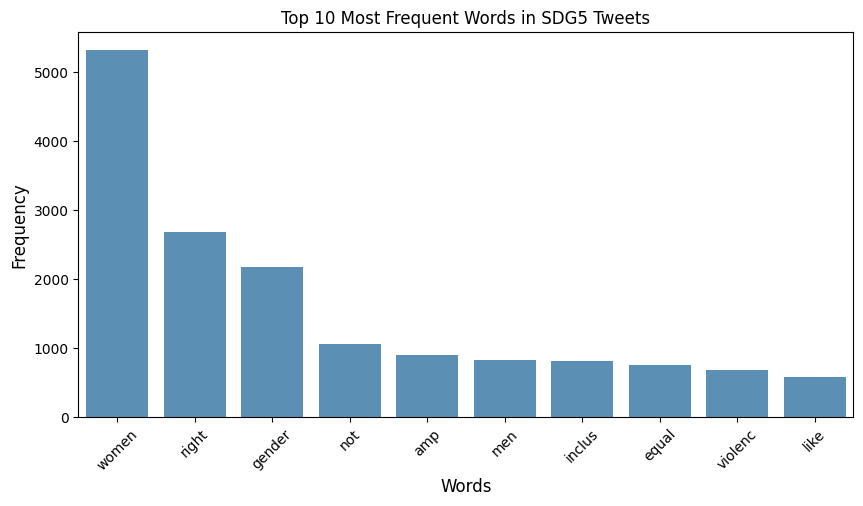

In [16]:
# Visualize top 10 word frequencies
import matplotlib.pyplot as plt
import seaborn as sns

top_words = word_frequency[:10]

plt.figure(figsize=(10, 5))
sns.barplot(x=top_words.index, y=top_words.values, alpha=0.8)
plt.title('Top 10 Most Frequent Words in SDG5 Tweets')
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Words', fontsize=12)
plt.xticks(rotation=45)
plt.show()


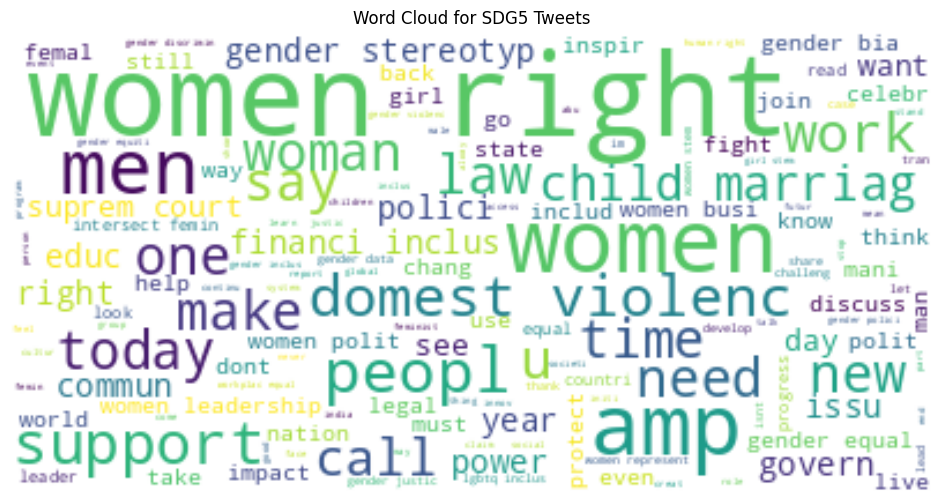

In [17]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

corpus = " ".join(df_sdg5['stemmed_text'])

# Generate the word cloud
wordcloud = WordCloud(
    background_color='white',
    max_words=200,
    max_font_size=50,
    random_state=42
).generate(corpus)

# Display the word cloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud for SDG5 Tweets")
plt.show()


# Remove Common Words

In [18]:
# Define domain-specific words to remove (custom stopwords)
common_words_sdg5 = ["gender", "equality", "woman", "women", "sdg", "equal", "rights", "female", "male", "girl", "boy"]

# Remove common words
df_sdg5['final_text'] = df_sdg5['stemmed_text'].apply(
    lambda x: " ".join([word for word in x.split() if word not in common_words_sdg5])
)

# Preview the cleaned final text
df_sdg5[['stemmed_text', 'final_text']].head()


,stemmed_text,final_text
0,kati perri gayl king go ride shape rocket supp...,kati perri gayl king go ride shape rocket supp...
1,saint dr msg insan start mani initi women empo...,saint dr msg insan start mani initi empower ne...
2,still mother still entrepreneur still everyth ...,still mother still entrepreneur still everyth ...
3,ashram matter epicent year seva includ uplift ...,ashram matter epicent year seva includ uplift ...
4,space mission pr stunt rich women paid float m...,space mission pr stunt rich paid float min cal...


# Sprint 2: N-grams Analysis

### Bigrams

In [19]:
# Rename 'Text' column to 'content' to match workshop convention
df_edu.rename(columns={'Text': 'content'}, inplace=True)


<ipython-input-20-6b9d9d7f0774>:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  h.set_xticklabels(h.get_xticklabels(), rotation=90)


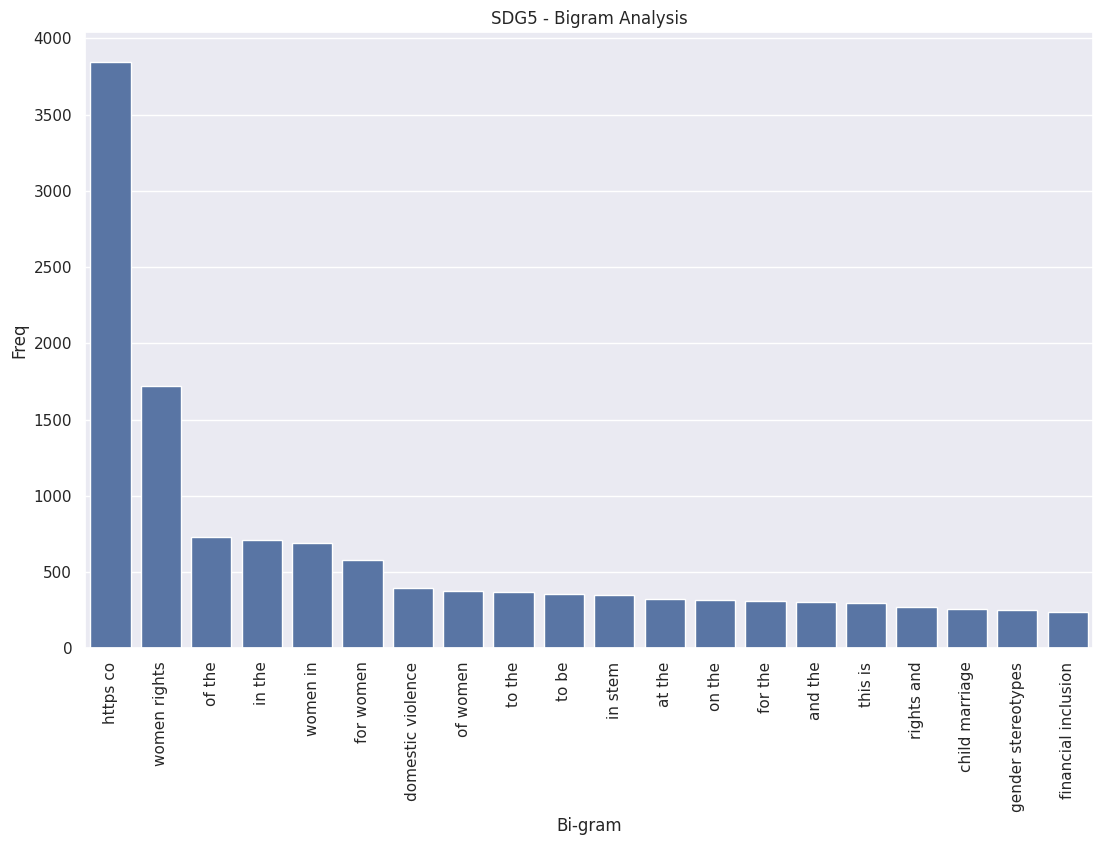

In [20]:
from sklearn.feature_extraction.text import CountVectorizer

def get_ngrams(corpus, ngram_range=(2, 2)):
    vec1 = CountVectorizer(ngram_range=ngram_range, max_features=2000).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec1.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq

# Get top bigrams
bigrams_sdg5 = get_ngrams(df_edu['content'])

# Convert to DataFrame
bigrams_df = pd.DataFrame(bigrams_sdg5, columns=["Bi-gram", "Freq"])

# Plot bigrams
import seaborn as sns
import matplotlib.pyplot as plt

top_bigrams_to_show = 20
sns.set(rc={'figure.figsize':(13,8)})
h = sns.barplot(x="Bi-gram", y="Freq", data=bigrams_df[:top_bigrams_to_show])
h.set_xticklabels(h.get_xticklabels(), rotation=90)
plt.title("SDG5 - Bigram Analysis")
plt.show()


### Trigrams

<ipython-input-21-b8f9a3e8e7cb>:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  h.set_xticklabels(h.get_xticklabels(), rotation=90)


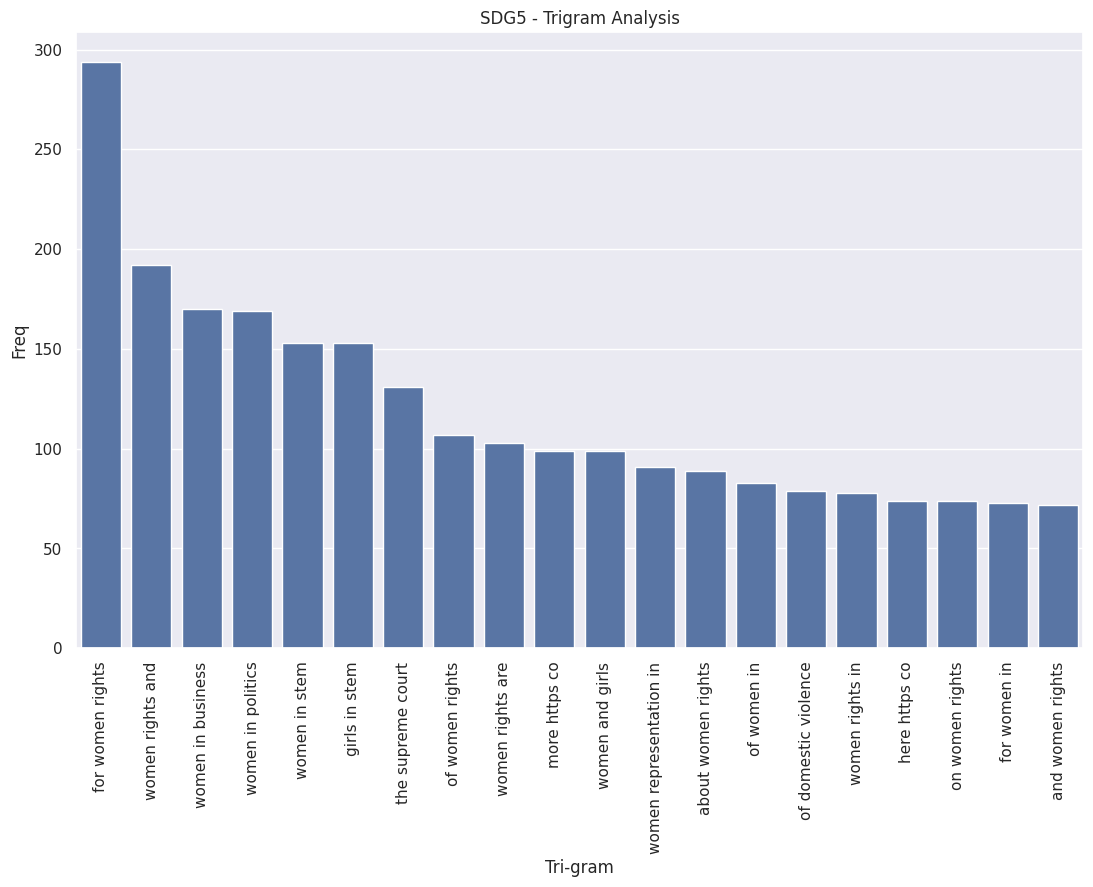

In [21]:
trigrams_sdg5 = get_ngrams(df_edu['content'].tolist(), ngram_range=(3, 3))

trigrams_sdg5_df = pd.DataFrame(trigrams_sdg5)
trigrams_sdg5_df.columns = ["Tri-gram", "Freq"]

top_trigrams_to_show = 20

sns.set(rc={'figure.figsize':(13,8)})
h = sns.barplot(x="Tri-gram", y="Freq", data=trigrams_sdg5_df[:top_trigrams_to_show])
h.set_xticklabels(h.get_xticklabels(), rotation=90)
plt.title('SDG5 - Trigram Analysis')
plt.show()



# Temporal Analysis

In [22]:
df_sdg5_processed = df_sdg5.copy()


In [23]:
df_sdg5_datewise = df_sdg5_processed.groupby(['day'])['Text'].count().reset_index(name='tweet_count_sdg5').set_index('day')


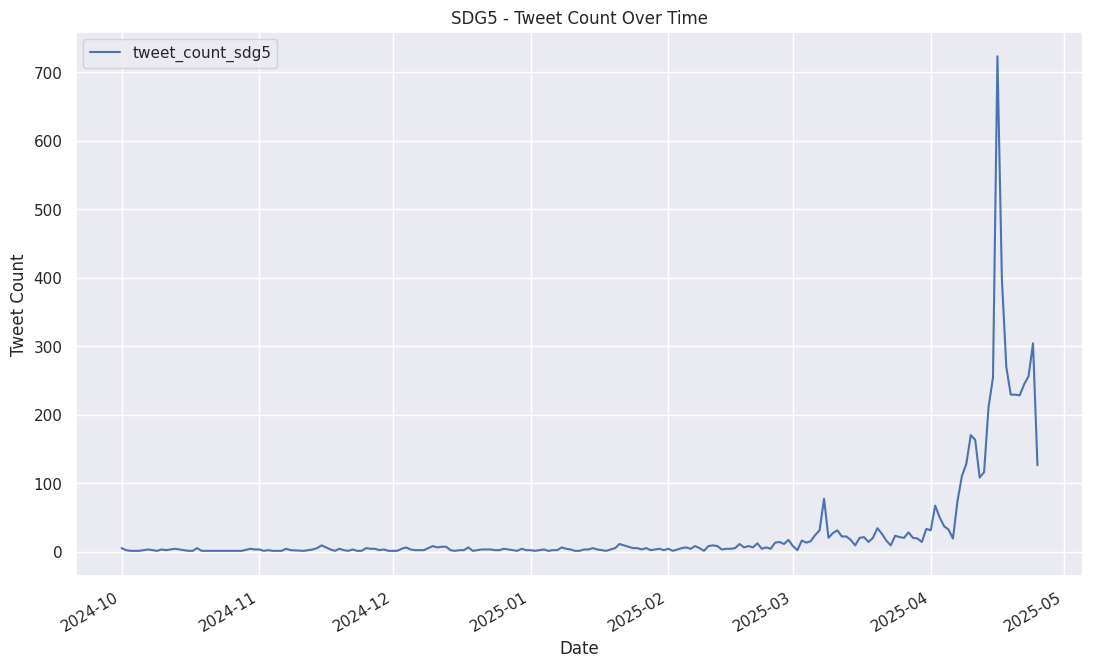

In [24]:
# Plot the SDG5 tweet count over time
ax = df_sdg5_datewise.plot()
plt.title("SDG5 - Tweet Count Over Time")
plt.xlabel("Date")
plt.ylabel("Tweet Count")
plt.savefig("temporal_analysis_sdg5.png", dpi=800)
plt.show()


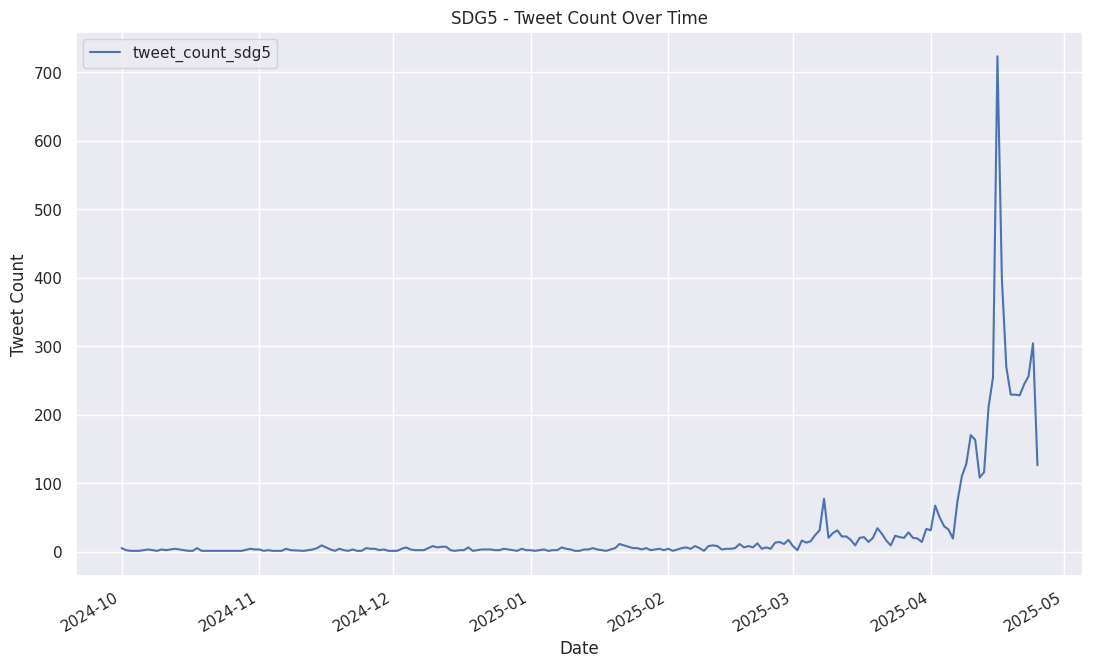

In [25]:
# Plot the SDG5 tweet count over time
ax = df_sdg5_datewise.plot()
plt.title("SDG5 - Tweet Count Over Time")
plt.xlabel("Date")
plt.ylabel("Tweet Count")
plt.savefig("temporal_analysis_sdg5.png", dpi=800)
plt.show()


# Sentiment Analysis

In [26]:
from textblob import TextBlob

df_sdg5['sentiment'] = df_sdg5['Text'].apply(lambda x: TextBlob(x).sentiment.polarity)

df_sdg5[['Text', 'sentiment']].head(50)


,Text,sentiment
0,Katy Perry and Gayle King go for a ride in a *...,0.038068
1,Saint Dr MSG Insan started many initiative for...,0.166667
2,She can still be a MOTHER \nShe can still be a...,0.050000
3,Ashram Matters - it is epicenter of 50+ Years ...,0.000000
4,Space mission or PR stunt? Rich women paid $11...,0.243750
5,Thank you beautiful warriors for your love and...,0.616667
6,So much for supporting women—this student trie...,0.225000
7,The girls are hugging and holding hands togeth...,0.000000
8,"In today’s era, women empowerment is key to so...",0.008333
9,"ADMK stands for Humanity, Unity, Equality, Soc...",0.219444


In [27]:
df_senti_sdg5_date_wise = df_sdg5.groupby(['day'])['sentiment'].mean().reset_index(name='mean_sentiment_sdg5').set_index('day')


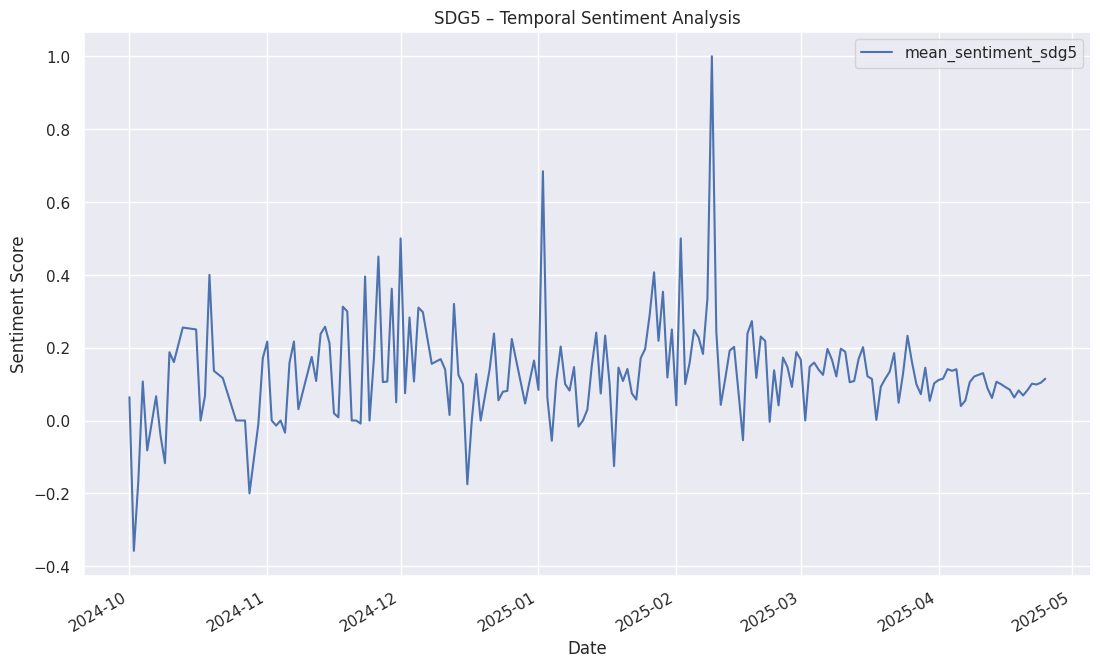

In [28]:
# 4. Plot sentiment trend over time
ax = df_senti_sdg5_date_wise.plot(figsize=(13,8))
plt.title("SDG5 – Temporal Sentiment Analysis")
plt.ylabel("Sentiment Score")
plt.xlabel("Date")
plt.grid(True)
plt.savefig("temporal_sentiment_sdg5.png", dpi=800)
plt.show()


# Topic Modelling

In [29]:
import gensim
from gensim import corpora
from gensim.models import LdaModel
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt

TEMP_FOLDER = tempfile.gettempdir()
print(f'Folder "{TEMP_FOLDER}" will be used to save temporary dictionary and corpus.')
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# Convert SDG5 tweets as text corpus
corpus = list(df_sdg5_processed['Text'])

# Tokenization
sdg5_texts = [[word for word in str(document).split()] for document in corpus]

# Create dictionary
dictionary = corpora.Dictionary(sdg5_texts)

# Save dictionary (optional)
dictionary.save(os.path.join(TEMP_FOLDER, 'sdg5.dict'))

# Convert to bag-of-words model
bow_corpus = [dictionary.doc2bow(text) for text in sdg5_texts]

# Train LDA model
lda_model = LdaModel(
    corpus=bow_corpus,
    id2word=dictionary,
    num_topics=5,
    random_state=42,
    update_every=1,
    chunksize=100,
    passes=10,
    alpha='auto',
    per_word_topics=True
)

# Display discovered topics
for idx, topic in lda_model.print_topics(-1):
    print(f"Topic: {idx}\nWords: {topic}\n")



Folder "/tmp" will be used to save temporary dictionary and corpus.
Topic: 0
Words: 0.011*"—" + 0.008*"Our" + 0.008*"government" + 0.007*"real" + 0.007*"inclusion" + 0.006*"promote" + 0.005*"isn't" + 0.005*"DEI" + 0.004*"constitutional" + 0.004*"white"

Topic: 1
Words: 0.050*"the" + 0.040*"and" + 0.039*"to" + 0.036*"in" + 0.029*"of" + 0.025*"a" + 0.019*"for" + 0.017*"gender" + 0.015*"is" + 0.013*"women"

Topic: 2
Words: 0.017*"you" + 0.017*"I" + 0.012*"about" + 0.009*"your" + 0.008*"policy" + 0.007*"business" + 0.007*"-" + 0.007*"her" + 0.007*"it" + 0.006*"feminism"

Topic: 3
Words: 0.020*"Business" + 0.015*"inclusivity" + 0.012*"2025" + 0.006*"Equality" + 0.006*"|" + 0.005*"key" + 0.005*"inspiring" + 0.005*"workplace" + 0.005*"leadership" + 0.005*"commitment"

Topic: 4
Words: 0.012*"into" + 0.006*"Day" + 0.006*"March" + 0.006*"May" + 0.006*"call" + 0.006*"✅" + 0.005*"federal" + 0.005*"UN" + 0.005*"Trump" + 0.005*"it."



In [30]:
# Visualize with pyLDAvis
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, bow_corpus, dictionary)
pyLDAvis.display(vis)

# Daily Insight Extraction from SDG5 Tweets using Generative AI

To gain deeper insights from the SDG5 tweets, we used a pre-trained emotion classification model from Hugging Face (SamLowe/roberta-base-go_emotions). This model allows us to detect the emotional tone of each tweet. After applying the model, we observed the distribution of emotions expressed in SDG5-related tweets. The top recurring emotions provide valuable understanding of public sentiment around gender equality issues, which can help policymakers and communicators tailor more effective messaging.

In [32]:
from transformers import pipeline
import pandas as pd

df_sdg5 = df[df["provider"] == "sdg5"].reset_index(drop=True)

classifier = pipeline(
    task="text-classification",
    model="SamLowe/roberta-base-go_emotions",
    top_k=None,
    truncation=True,
    max_length=512
)

def find_emotion(text):
    if not isinstance(text, str) or text.strip() == "":
        return "uncategorized"
    try:
        result = classifier(text)
        return result[0][0]['label']
    except:
        return "uncategorized"

df_sdg5["emotion"] = df_sdg5["Text"].apply(find_emotion)

df_sdg5["emotion"].value_counts()


NameError: name 'df' is not defined